In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# RBF (Radial Basis Functions) pentru regresie

## 1. Introducere

Vom folosi o reţea RBF cu K centri pentru a realiza o regresie. Intrările regresie (stratului ascuns) vor fi un set de K feature-uri 'fabricate' de cele K funcţii radiale. Pe baza acestora vom construi regresia liniară, care este o combinaţie liniară de aceste intrări radiale. Coeficienţii regresiei liniare se învaţă cu ajutorul algoritmului backpropagation.

Funcţia de activare radială $k$ pentru o intrare $x^{(i)}$, un centroid $c_k$ respectiv o 'lăţime' $\sigma_k$ a gaussienei ce o caracterizează este:

$\varphi_k(x^{(i)}) = exp\left( - \frac{\|x^{(i)}-c_k\|^2}{2\sigma_k^2} \right)$

Funcţia de loss pentru un set de date întreg $x^{(i)}, y^{(i)}$, pentru $i = 1 \dots N$, este:

$J(x, y) = \frac{1}{2}\sum_{i=1}^N \left[ y^{(i)} - f(x^{(i)}) \right]$, pentru care:

$f(x^{(i)}) = \sum_{k=1}^K w_k \varphi_k(x^{(i)})$

Vom calcula însă eroarea de propagare înapoi pentru fiecare $x^{(i)}$ în parte, aşa încât funcţia de loss la fiecare pas este:

$J(x^{(i)}, y^{(i)}) = \frac{1}{2} \left[ y^{(i)} - f(x^{(i)}) \right]$

Putem astfel construi:

$\frac{\partial J_i}{\partial w_k} = \frac{\partial J}{\partial f_i} \cdot \frac{\partial f_i}{\partial w_k} = - \left[ y^{(i)} - f(x^{(i)}) \right] \varphi_k(x^{(i)})$, respectiv:

$\frac{\partial J_i}{\partial b} - \left[ y^{(i)} - f(x^{(i)}) \right]$


Regulile de update devin astfel:

$w_k \leftarrow w_k + \left[ y^{(i)} - f(x^{(i)}) \right] \varphi_k(x^{(i)})$, şi:

$b \leftarrow b + \left[ y^{(i)} - f(x^{(i)}) \right])$


## 2. Setul de date

Sunt alese aleator 100 de puncte între $[0, 1)$, şi construim o 'sinusoidă' perturbată pentru punctele astfel alese:

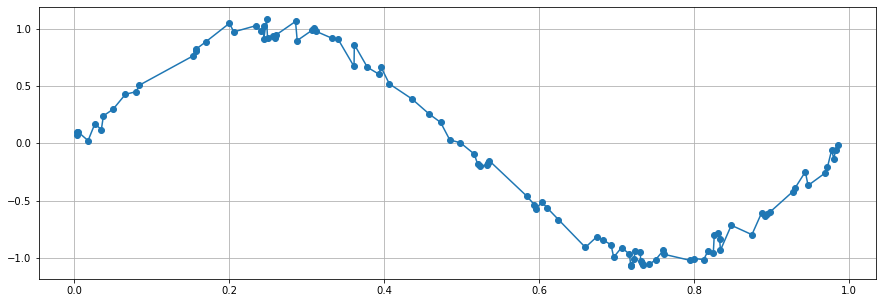

In [15]:
samples = 100
x = np.random.uniform(low=0.0, high=1.0, size=samples)
x = np.sort(x, axis=0)

noise = np.random.uniform(low=-0.1, high=0.1, size=samples)
y = np.sin(2 * np.pi * x)  + noise
 
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x, y, '-o')
ax.grid() ; plt.show() 

## 3. Algoritmul K-means

K-means este folosit pentru construcţia centroizilor. Acolo vom 'centra' cele K gaussiene.

1. se aleg cei K centri aleator dintre cele 100 de puncte existente
2. calculează distanţa de la fiecare punct la fiecare dintre cei K centroizi
3. pentru fiecare punct, se găseşte cel mai apropiat centroid de punctul respectiv
4. pentru fiecare din cei K centroizi, se recalculează media cluster-ului ca fiind media punctelor celor mai apropiate de acel centroid
5. centroidul devine media astfel calculată
6. repetă paşii 2 - 5 până când centroizii au o deplasare sub $10^{-6}$

Algoritmul K-means va întoarce centroizii împreună cu deviaţia standard a fiecărui cluster, asociat acelui centroid.

Dacă există clustere cu mai puţin de doi reprezentanţi, deviaţia standard ($\sigma$) a acelui cluster va fi calculată ca media clusterelor care nu se află în această situaţie.

In [16]:
def kmeans(x, k):
    # choose k centers at random, from existing samples
    
    # centers = np.random.choice(x, size = k, replace = False)
        
    remaining_x = x
    centers = np.random.choice(len(x), size = 1, replace = False)
    remaining_x = np.delete(x, centers)
    
    for i in range(k-1):
        dist = [np.array(np.abs(remaining_x - x[center])) for center in centers]
        dist = np.asarray(dist)
        
        dist_min = np.array(dist)
        dist_min = np.min(dist_min, axis=0)
        
        probabilities = (dist_min / np.sum(dist_min))
        
        new_center = np.random.choice(len(remaining_x), size = 1, replace = False, p = probabilities)
        centers = np.append(centers, new_center)
        remaining_x = np.delete(x, new_center)
    
    centers = x[centers]
    
    converged = False
    while not converged:
        # compute distance from every point to all centers
        distances = []
        for point in x:
            closest = centers[0]
            for center in centers:
                if np.abs(closest - point) > np.abs(center - point):
                    closest = center
            distances.append(closest)
        
        # recompute the centers by computing the mean of every cluster
        prev_centers = centers
        
        centers = np.array([x[distances == center].mean(0) for center in centers])
            
        converged = np.linalg.norm(centers - prev_centers) < 1e-6
    
    # compute the standard deviations of clusters
    dmax = 0
    for nr in range(len(centers)):
        for nr2 in range(nr + 1, len(centers)):
            if dmax < np.abs(centers[nr] - centers[nr2]):
                dmax = np.abs(centers[nr] - centers[nr2])
    
    sigma = dmax / np.sqrt(2 * k)
    
    # find clusters with less than 2 points and make std = 0
    stds = np.array([0 if np.sum(x[distances == center]) < 2 else sigma for center in centers])
    
    # set the cluster std as the mean of the rest of stds, for those clusters with std = 0
    if len(stds[stds == 0]) > 0:
        stds[stds == 0] = stds[stds != 0].mean()
    return centers, stds

In [17]:
k = 16 # 50
centers, stds = kmeans(x, k)

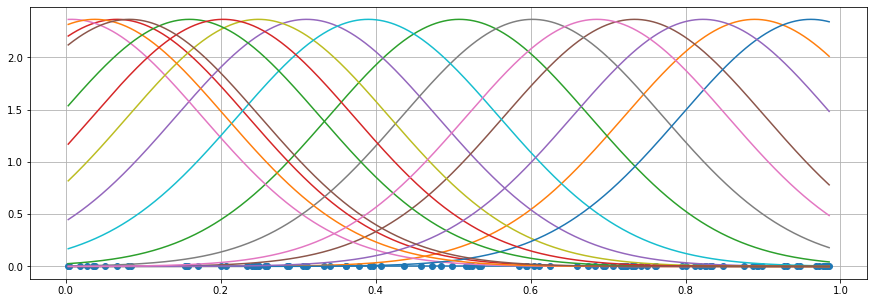

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x, np.zeros_like(x), '-o')
v = np.linspace(x.min(), x.max(), 1000)
for i in range(k):
    ax.plot(v, stats.norm.pdf(v, loc=centers[i], scale=stds[i]))
ax.grid() ; plt.show() 

Observaţi cum apar mai multe gaussiene în zonele cu puncte mai dese. Încercaţi să modificaţi numărul de clustere.

In [19]:
def rbf(x, c, sigma):
#     print(x-c)
    return np.exp(- (x - c) ** 2 / (2 * sigma ** 2))

## 4. Instruirea ponderilor stratului ascuns

Realizaţi, în fiecare epocă, parcurgerea sample cu sample. Pentru fiecare sample $x^{(i)}$ astfel ales, calculaţi valoarea activării (funcţia $f(\cdot)$), loss-ului şi a lui delta.

In [20]:
lr = 0.05
epochs = 200
w = np.random.randn(k)

for epoch in range(epochs):
    for i in range(len(x)):
        # outputs from hidden layer
        a = rbf(x[i], centers, stds[0])
        # network's output
        f = w @ a
        loss = (y[i] - f) ** 2
        delta = -y[i] + f
        
        w -= lr * delta * a

[-0.88628314 -0.50489067 -0.0630343  -0.30767798 -0.73118214 -0.00417377
 -0.59929736 -0.24564496 -0.38736746 -0.95865785 -0.03430261 -0.15648472
 -0.20009183 -0.81946563 -0.07884012 -0.68248862]
[-0.88555615 -0.50416368 -0.06230732 -0.30695099 -0.73045515 -0.00344678
 -0.59857037 -0.24491797 -0.38664047 -0.95793086 -0.03357563 -0.15575773
 -0.19936484 -0.81873864 -0.07811313 -0.68176163]
[-0.88508317 -0.5036907  -0.06183434 -0.30647801 -0.72998217 -0.0029738
 -0.59809739 -0.24444499 -0.38616749 -0.95745788 -0.03310265 -0.15528475
 -0.19889186 -0.81826566 -0.07764015 -0.68128865]
[-0.87151503 -0.49012255 -0.04826619 -0.29290986 -0.71641402  0.01059435
 -0.58452924 -0.23087685 -0.37259935 -0.94388973 -0.0195345  -0.14171661
 -0.18532371 -0.80469752 -0.064072   -0.6677205 ]
[-0.86269776 -0.48130528 -0.03944892 -0.28409259 -0.70759675  0.01941162
 -0.57571197 -0.22205958 -0.36378208 -0.93507246 -0.01071723 -0.13289934
 -0.17650644 -0.79588025 -0.05525473 -0.65890323]
[-0.85438779 -0.47299

  0.51358634 -0.10578746  0.63483805  0.03118955]
[-0.17088214  0.21051034  0.6523667   0.40772303 -0.01578113  0.71122724
  0.11610365  0.46975604  0.32803354 -0.24325684  0.68109839  0.55891628
  0.51530917 -0.10406463  0.63656089  0.03291238]
[-0.17004742  0.21134506  0.65320142  0.40855775 -0.01494641  0.71206196
  0.11693837  0.47059076  0.32886826 -0.24242212  0.68193311  0.559751
  0.51614389 -0.10322991  0.63739561  0.0337471 ]
[-0.16691315  0.21447933  0.65633569  0.41169202 -0.01181215  0.71519622
  0.12007263  0.47372503  0.33200253 -0.23928785  0.68506738  0.56288527
  0.51927816 -0.10009564  0.64052988  0.03688137]
[-0.16508368  0.2163088   0.65816516  0.41352149 -0.00998268  0.71702569
  0.1219021   0.4755545   0.333832   -0.23745838  0.68689685  0.56471474
  0.52110763 -0.09826617  0.64235935  0.03871084]
[-0.15838727  0.22300521  0.66486157  0.4202179  -0.00328626  0.72372211
  0.12859852  0.48225091  0.34052841 -0.23076197  0.69359326  0.57141115
  0.52780405 -0.091569

 0.77975535 0.16038154 0.90100706 0.29735856]
[0.09607152 0.47746399 0.91932035 0.67467668 0.25117252 0.97818089
 0.3830573  0.7367097  0.5949872  0.02369681 0.94805204 0.82586994
 0.78226283 0.16288903 0.90351454 0.29986604]
[-0.88628314 -0.50489067 -0.0630343  -0.30767798 -0.73118214 -0.00417377
 -0.59929736 -0.24564496 -0.38736746 -0.95865785 -0.03430261 -0.15648472
 -0.20009183 -0.81946563 -0.07884012 -0.68248862]
[-0.88555615 -0.50416368 -0.06230732 -0.30695099 -0.73045515 -0.00344678
 -0.59857037 -0.24491797 -0.38664047 -0.95793086 -0.03357563 -0.15575773
 -0.19936484 -0.81873864 -0.07811313 -0.68176163]
[-0.88508317 -0.5036907  -0.06183434 -0.30647801 -0.72998217 -0.0029738
 -0.59809739 -0.24444499 -0.38616749 -0.95745788 -0.03310265 -0.15528475
 -0.19889186 -0.81826566 -0.07764015 -0.68128865]
[-0.87151503 -0.49012255 -0.04826619 -0.29290986 -0.71641402  0.01059435
 -0.58452924 -0.23087685 -0.37259935 -0.94388973 -0.0195345  -0.14171661
 -0.18532371 -0.80469752 -0.064072   -0.6

  0.38158593 -0.23778787  0.50283764 -0.10081086]
[-0.29557475  0.08581772  0.52767408  0.28303041 -0.14047375  0.58653462
 -0.00858897  0.34506343  0.20334093 -0.36794946  0.55640578  0.43422367
  0.39061656 -0.22875724  0.51186827 -0.09178023]
[-0.29354347  0.087849    0.52970537  0.28506169 -0.13844247  0.5885659
 -0.00655769  0.34709471  0.20537221 -0.36591818  0.55843706  0.43625495
  0.39264784 -0.22672596  0.51389955 -0.08974895]
[-0.2855343   0.09585817  0.53771453  0.29307086 -0.1304333   0.59657507
  0.00145148  0.35510388  0.21338138 -0.35790901  0.56644622  0.44426412
  0.40065701 -0.21871679  0.52190872 -0.08173978]
[-0.27839382  0.10299866  0.54485502  0.30021135 -0.12329281  0.60371556
  0.00859197  0.36224436  0.22052186 -0.35076852  0.57358671  0.4514046
  0.4077975  -0.21157631  0.52904921 -0.07459929]
[-0.26426297  0.1171295   0.55898586  0.31434219 -0.10916197  0.6178464
  0.02272281  0.37637521  0.23465271 -0.33663768  0.58771755  0.46553545
  0.42192834 -0.1974454

 0.77747764 0.15810383 0.89872935 0.29508085]
[0.09356403 0.47495651 0.91681287 0.6721692  0.24866504 0.97567341
 0.38054982 0.73420221 0.59247971 0.02118933 0.94554456 0.82336245
 0.77975535 0.16038154 0.90100706 0.29735856]
[0.09607152 0.47746399 0.91932035 0.67467668 0.25117252 0.97818089
 0.3830573  0.7367097  0.5949872  0.02369681 0.94805204 0.82586994
 0.78226283 0.16288903 0.90351454 0.29986604]
[-0.88628314 -0.50489067 -0.0630343  -0.30767798 -0.73118214 -0.00417377
 -0.59929736 -0.24564496 -0.38736746 -0.95865785 -0.03430261 -0.15648472
 -0.20009183 -0.81946563 -0.07884012 -0.68248862]
[-0.88555615 -0.50416368 -0.06230732 -0.30695099 -0.73045515 -0.00344678
 -0.59857037 -0.24491797 -0.38664047 -0.95793086 -0.03357563 -0.15575773
 -0.19936484 -0.81873864 -0.07811313 -0.68176163]
[-0.88508317 -0.5036907  -0.06183434 -0.30647801 -0.72998217 -0.0029738
 -0.59809739 -0.24444499 -0.38616749 -0.95745788 -0.03310265 -0.15528475
 -0.19889186 -0.81826566 -0.07764015 -0.68128865]
[-0.871

 -0.19936484 -0.81873864 -0.07811313 -0.68176163]
[-0.88508317 -0.5036907  -0.06183434 -0.30647801 -0.72998217 -0.0029738
 -0.59809739 -0.24444499 -0.38616749 -0.95745788 -0.03310265 -0.15528475
 -0.19889186 -0.81826566 -0.07764015 -0.68128865]
[-0.87151503 -0.49012255 -0.04826619 -0.29290986 -0.71641402  0.01059435
 -0.58452924 -0.23087685 -0.37259935 -0.94388973 -0.0195345  -0.14171661
 -0.18532371 -0.80469752 -0.064072   -0.6677205 ]
[-0.86269776 -0.48130528 -0.03944892 -0.28409259 -0.70759675  0.01941162
 -0.57571197 -0.22205958 -0.36378208 -0.93507246 -0.01071723 -0.13289934
 -0.17650644 -0.79588025 -0.05525473 -0.65890323]
[-0.85438779 -0.47299532 -0.03113895 -0.27578262 -0.69928679  0.02772158
 -0.56740201 -0.21374961 -0.35547211 -0.9267625  -0.00240726 -0.12458937
 -0.16819648 -0.78757028 -0.04694476 -0.65059327]
[-8.51690438e-01 -4.70297963e-01 -2.84416004e-02 -2.73085272e-01
 -6.96589434e-01  3.04189356e-02 -5.64704655e-01 -2.11052259e-01
 -3.52774759e-01 -9.24065144e-01  2.9

  0.63004331  0.01066951  0.75129502  0.14764652]
[-0.05506864  0.32632383  0.76818019  0.52353652  0.10003236  0.82704073
  0.23191714  0.58556953  0.44384703 -0.12744335  0.79691188  0.67472978
  0.63112267  0.01174887  0.75237438  0.14872588]
[-0.04105778  0.3403347   0.78219106  0.53754739  0.11404323  0.8410516
  0.24592801  0.5995804   0.4578579  -0.11343248  0.81092275  0.68874064
  0.64513354  0.02575973  0.76638525  0.16273674]
[-0.0144608   0.36693168  0.80878804  0.56414437  0.14064021  0.86764858
  0.27252499  0.62617738  0.48445488 -0.0868355   0.83751973  0.71533762
  0.67173052  0.05235671  0.79298223  0.18933372]
[-0.00180793  0.37958455  0.82144091  0.57679724  0.15329308  0.88030145
  0.28517786  0.63883025  0.49710775 -0.07418263  0.8501726   0.72799049
  0.68438339  0.06500958  0.8056351   0.2019866 ]
[ 0.00246112  0.38385359  0.82570995  0.58106628  0.15756212  0.88457049
  0.2894469   0.6430993   0.5013768  -0.06991359  0.85444164  0.73225954
  0.68865243  0.06927

 -0.119349   -0.73872281  0.00190271 -0.60174579]
[-0.73546712 -0.35407465  0.08778171 -0.15686196 -0.58036612  0.14664225
 -0.44848134 -0.09482894 -0.23655144 -0.80784183  0.1165134  -0.0056687
 -0.04927581 -0.66864961  0.0719759  -0.5316726 ]
[-0.73266903 -0.35127656  0.0905798  -0.15406387 -0.57756803  0.14944034
 -0.44568325 -0.09203086 -0.23375335 -0.80504374  0.11931149 -0.00287061
 -0.04647772 -0.66585152  0.07477399 -0.52887451]
[-0.73167386 -0.35028138  0.09157498 -0.15306869 -0.57657286  0.15043551
 -0.44468808 -0.09103568 -0.23275818 -0.80404856  0.12030667 -0.00187544
 -0.04548255 -0.66485635  0.07576917 -0.52787934]
[-0.71938367 -0.33799119  0.10386517 -0.1407785  -0.56428266  0.16272571
 -0.43239788 -0.07874549 -0.22046799 -0.79175837  0.13259686  0.01041475
 -0.03319235 -0.65256616  0.08805936 -0.51558914]
[-0.68912126 -0.30772878  0.13412758 -0.11051609 -0.53402025  0.19298812
 -0.40213547 -0.04848308 -0.19020558 -0.76149596  0.16285927  0.04067716
 -0.00292995 -0.62230

  0.49328685 -0.12608695  0.61453856  0.01089006]
[-0.18276869  0.19862379  0.64048015  0.39583648 -0.02766769  0.69934068
  0.10421709  0.45786949  0.31614699 -0.2551434   0.66921184  0.54702973
  0.50342262 -0.11595118  0.62467434  0.02102583]
[-0.17260497  0.2087875   0.65064387  0.40600019 -0.01750397  0.7095044
  0.11438081  0.46803321  0.32631071 -0.24497968  0.67937556  0.55719345
  0.51358634 -0.10578746  0.63483805  0.03118955]
[-0.17088214  0.21051034  0.6523667   0.40772303 -0.01578113  0.71122724
  0.11610365  0.46975604  0.32803354 -0.24325684  0.68109839  0.55891628
  0.51530917 -0.10406463  0.63656089  0.03291238]
[-0.17004742  0.21134506  0.65320142  0.40855775 -0.01494641  0.71206196
  0.11693837  0.47059076  0.32886826 -0.24242212  0.68193311  0.559751
  0.51614389 -0.10322991  0.63739561  0.0337471 ]
[-0.16691315  0.21447933  0.65633569  0.41169202 -0.01181215  0.71519622
  0.12007263  0.47372503  0.33200253 -0.23928785  0.68506738  0.56288527
  0.51927816 -0.1000956

  0.08250874 -0.53686506  0.20376046 -0.39988805]
[-0.60148852 -0.22009604  0.22176032 -0.02288335 -0.44638751  0.28062086
 -0.31450273  0.03914966 -0.10257284 -0.67386322  0.25049201  0.1283099
  0.08470279 -0.53467101  0.20595451 -0.397694  ]
[-0.58276506 -0.20137259  0.24048378 -0.0041599  -0.42766406  0.29934431
 -0.29577928  0.05787312 -0.08384938 -0.65513977  0.26921547  0.14703336
  0.10342625 -0.51594755  0.22467796 -0.37897054]
[-0.57978711 -0.19839463  0.24346173 -0.00118194 -0.42468611  0.30232226
 -0.29280133  0.06085107 -0.08087143 -0.65216182  0.27219342  0.15001131
  0.1064042  -0.5129696   0.22765592 -0.37599259]
[-0.57760668 -0.1962142   0.24564216  0.00099849 -0.42250567  0.3045027
 -0.29062089  0.0630315  -0.078691   -0.64998138  0.27437385  0.15219174
  0.10858464 -0.51078917  0.22983635 -0.37381215]
[-0.556028   -0.17463553  0.26722083  0.02257716 -0.400927    0.32608137
 -0.26904222  0.08461018 -0.05711232 -0.62840271  0.29595252  0.17377042
  0.13016331 -0.489210

  0.03774601 -0.58162779  0.15899773 -0.44465078]
[-0.64486945 -0.26347698  0.17837938 -0.06626429 -0.48976845  0.23723992
 -0.35788367 -0.00423127 -0.14595377 -0.71724416  0.20711107  0.08492897
  0.04132186 -0.57805194  0.16257357 -0.44107493]
[-0.64458816 -0.26319568  0.17866068 -0.06598299 -0.48948715  0.23752122
 -0.35760237 -0.00394998 -0.14567248 -0.71696286  0.20739237  0.08521026
  0.04160316 -0.57777065  0.16285487 -0.44079364]
[-6.41081982e-01 -2.59689507e-01  1.82166855e-01 -6.24768172e-02
 -4.85980979e-01  2.41027391e-01 -3.54096200e-01 -4.43803556e-04
 -1.42166304e-01 -7.13456688e-01  2.10898545e-01  8.87164377e-02
  4.51093296e-02 -5.74264473e-01  1.66361043e-01 -4.37287461e-01]
[-0.63978695 -0.25839447  0.18346189 -0.06118178 -0.48468594  0.24232243
 -0.35280116  0.00085123 -0.14087127 -0.71216165  0.21219358  0.09001148
  0.04640437 -0.57296944  0.16765608 -0.43599242]
[-0.63279952 -0.25140705  0.19044932 -0.05419435 -0.47769852  0.24930985
 -0.34581374  0.00783866 -0.

  0.00292995 -0.61644386  0.12418166 -0.47946685]
[-0.65500365 -0.27361117  0.16824519 -0.07639848 -0.49990265  0.22710572
 -0.36801787 -0.01436547 -0.15608797 -0.72737835  0.19697688  0.07479477
  0.03118766 -0.58818614  0.15243938 -0.45120913]
[-0.6484453  -0.26705282  0.17480354 -0.06984013 -0.49334429  0.23366408
 -0.36145951 -0.00780712 -0.14952962 -0.72082     0.20353523  0.08135312
  0.03774601 -0.58162779  0.15899773 -0.44465078]
[-0.64486945 -0.26347698  0.17837938 -0.06626429 -0.48976845  0.23723992
 -0.35788367 -0.00423127 -0.14595377 -0.71724416  0.20711107  0.08492897
  0.04132186 -0.57805194  0.16257357 -0.44107493]
[-0.64458816 -0.26319568  0.17866068 -0.06598299 -0.48948715  0.23752122
 -0.35760237 -0.00394998 -0.14567248 -0.71696286  0.20739237  0.08521026
  0.04160316 -0.57777065  0.16285487 -0.44079364]
[-6.41081982e-01 -2.59689507e-01  1.82166855e-01 -6.24768172e-02
 -4.85980979e-01  2.41027391e-01 -3.54096200e-01 -4.43803556e-04
 -1.42166304e-01 -7.13456688e-01  2.

  0.28167666 -0.33769715  0.40292837 -0.20072013]
[-0.39077412 -0.00938164  0.43247472  0.18783105 -0.23567312  0.49133525
 -0.10378834  0.24986406  0.10814156 -0.46314883  0.46120641  0.3390243
  0.29541719 -0.32395661  0.41666891 -0.1869796 ]
[-0.37300613  0.00838635  0.45024271  0.20559904 -0.21790513  0.50910324
 -0.08602035  0.26763205  0.12590955 -0.44538084  0.4789744   0.35679229
  0.31318518 -0.30618862  0.4344369  -0.16921161]
[-0.36856539  0.01282708  0.45468345  0.21003977 -0.21346439  0.51354398
 -0.08157961  0.27207279  0.13035029 -0.4409401   0.48341514  0.36123303
  0.31762592 -0.30174788  0.43887763 -0.16477087]
[-0.36500861  0.01638387  0.45824023  0.21359656 -0.20990761  0.51710076
 -0.07802283  0.27562957  0.13390707 -0.43738332  0.48697192  0.36478981
  0.3211827  -0.2981911   0.44243442 -0.16121409]
[-0.3559432   0.02544928  0.46730564  0.22266197 -0.20084219  0.52616618
 -0.06895741  0.28469498  0.14297248 -0.4283179   0.49603733  0.37385522
  0.33024812 -0.28912

 -0.16819648 -0.78757028 -0.04694476 -0.65059327]
[-8.51690438e-01 -4.70297963e-01 -2.84416004e-02 -2.73085272e-01
 -6.96589434e-01  3.04189356e-02 -5.64704655e-01 -2.11052259e-01
 -3.52774759e-01 -9.24065144e-01  2.90089685e-04 -1.21892017e-01
 -1.65499126e-01 -7.84872928e-01 -4.42474118e-02 -6.47895916e-01]
[-0.83914613 -0.45775365 -0.01589729 -0.26054096 -0.68404512  0.04296325
 -0.55216034 -0.19850795 -0.34023045 -0.91152083  0.0128344  -0.10934771
 -0.15295481 -0.77232862 -0.0317031  -0.6353516 ]
[-0.82324884 -0.44185636  0.         -0.24464367 -0.66814783  0.05886054
 -0.53626305 -0.18261066 -0.32433316 -0.89562354  0.02873169 -0.09345042
 -0.13705753 -0.75643133 -0.01580581 -0.61945432]
[-0.80934574 -0.42795326  0.0139031  -0.23074057 -0.65424473  0.07276364
 -0.52235995 -0.16870756 -0.31043006 -0.88172044  0.04263479 -0.07954732
 -0.12315442 -0.74252823 -0.00190271 -0.60555121]
[-0.80554032 -0.42414784  0.01770852 -0.22693515 -0.65043931  0.07656906
 -0.51855453 -0.16490214 -0.

 -0.04548255 -0.66485635  0.07576917 -0.52787934]
[-0.71938367 -0.33799119  0.10386517 -0.1407785  -0.56428266  0.16272571
 -0.43239788 -0.07874549 -0.22046799 -0.79175837  0.13259686  0.01041475
 -0.03319235 -0.65256616  0.08805936 -0.51558914]
[-0.68912126 -0.30772878  0.13412758 -0.11051609 -0.53402025  0.19298812
 -0.40213547 -0.04848308 -0.19020558 -0.76149596  0.16285927  0.04067716
 -0.00292995 -0.62230375  0.11832177 -0.48532674]
[-0.68326137 -0.30186889  0.13998747 -0.1046562  -0.52816036  0.19884801
 -0.39627558 -0.04262319 -0.18434569 -0.75563607  0.16871916  0.04653705
  0.00292995 -0.61644386  0.12418166 -0.47946685]
[-0.65500365 -0.27361117  0.16824519 -0.07639848 -0.49990265  0.22710572
 -0.36801787 -0.01436547 -0.15608797 -0.72737835  0.19697688  0.07479477
  0.03118766 -0.58818614  0.15243938 -0.45120913]
[-0.6484453  -0.26705282  0.17480354 -0.06984013 -0.49334429  0.23366408
 -0.36145951 -0.00780712 -0.14952962 -0.72082     0.20353523  0.08135312
  0.03774601 -0.5816

  0.40065701 -0.21871679  0.52190872 -0.08173978]
[-0.27839382  0.10299866  0.54485502  0.30021135 -0.12329281  0.60371556
  0.00859197  0.36224436  0.22052186 -0.35076852  0.57358671  0.4514046
  0.4077975  -0.21157631  0.52904921 -0.07459929]
[-0.26426297  0.1171295   0.55898586  0.31434219 -0.10916197  0.6178464
  0.02272281  0.37637521  0.23465271 -0.33663768  0.58771755  0.46553545
  0.42192834 -0.19744546  0.54318005 -0.06046845]
[-0.22943616  0.15195632  0.59381268  0.34916901 -0.07433515  0.65267322
  0.05754963  0.41120202  0.26947952 -0.30181086  0.62254437  0.50036226
  0.45675516 -0.16261865  0.57800687 -0.02564163]
[-0.21477876  0.16661372  0.60847008  0.36382641 -0.05967775  0.66733062
  0.07220702  0.42585942  0.28413692 -0.28715346  0.63720177  0.51501966
  0.47141255 -0.14796125  0.59266427 -0.01098424]
[-0.2064497   0.17494277  0.61679913  0.37215546 -0.0513487   0.67565967
  0.08053608  0.43418848  0.29246598 -0.27882441  0.64553082  0.52334872
  0.47974161 -0.139632

 0.77747764 0.15810383 0.89872935 0.29508085]
[0.09356403 0.47495651 0.91681287 0.6721692  0.24866504 0.97567341
 0.38054982 0.73420221 0.59247971 0.02118933 0.94554456 0.82336245
 0.77975535 0.16038154 0.90100706 0.29735856]
[0.09607152 0.47746399 0.91932035 0.67467668 0.25117252 0.97818089
 0.3830573  0.7367097  0.5949872  0.02369681 0.94805204 0.82586994
 0.78226283 0.16288903 0.90351454 0.29986604]
[-0.88628314 -0.50489067 -0.0630343  -0.30767798 -0.73118214 -0.00417377
 -0.59929736 -0.24564496 -0.38736746 -0.95865785 -0.03430261 -0.15648472
 -0.20009183 -0.81946563 -0.07884012 -0.68248862]
[-0.88555615 -0.50416368 -0.06230732 -0.30695099 -0.73045515 -0.00344678
 -0.59857037 -0.24491797 -0.38664047 -0.95793086 -0.03357563 -0.15575773
 -0.19936484 -0.81873864 -0.07811313 -0.68176163]
[-0.88508317 -0.5036907  -0.06183434 -0.30647801 -0.72998217 -0.0029738
 -0.59809739 -0.24444499 -0.38616749 -0.95745788 -0.03310265 -0.15528475
 -0.19889186 -0.81826566 -0.07764015 -0.68128865]
[-0.871

  0.64513354  0.02575973  0.76638525  0.16273674]
[-0.0144608   0.36693168  0.80878804  0.56414437  0.14064021  0.86764858
  0.27252499  0.62617738  0.48445488 -0.0868355   0.83751973  0.71533762
  0.67173052  0.05235671  0.79298223  0.18933372]
[-0.00180793  0.37958455  0.82144091  0.57679724  0.15329308  0.88030145
  0.28517786  0.63883025  0.49710775 -0.07418263  0.8501726   0.72799049
  0.68438339  0.06500958  0.8056351   0.2019866 ]
[ 0.00246112  0.38385359  0.82570995  0.58106628  0.15756212  0.88457049
  0.2894469   0.6430993   0.5013768  -0.06991359  0.85444164  0.73225954
  0.68865243  0.06927863  0.80990414  0.20625564]
[ 0.00457608  0.38596856  0.82782492  0.58318125  0.15967709  0.88668546
  0.29156187  0.64521426  0.50349176 -0.06779862  0.85655661  0.7343745
  0.6907674   0.07139359  0.81201911  0.20837061]
[ 0.00923152  0.390624    0.83248036  0.58783669  0.16433252  0.89134089
  0.2962173   0.6498697   0.5081472  -0.06314318  0.86121205  0.73902994
  0.69542283  0.07604

 0.77467692 0.15530312 0.89592864 0.29228013]
[0.09128633 0.4726788  0.91453516 0.66989149 0.24638733 0.9733957
 0.37827211 0.7319245  0.590202   0.01891162 0.94326685 0.82108475
 0.77747764 0.15810383 0.89872935 0.29508085]
[0.09356403 0.47495651 0.91681287 0.6721692  0.24866504 0.97567341
 0.38054982 0.73420221 0.59247971 0.02118933 0.94554456 0.82336245
 0.77975535 0.16038154 0.90100706 0.29735856]
[0.09607152 0.47746399 0.91932035 0.67467668 0.25117252 0.97818089
 0.3830573  0.7367097  0.5949872  0.02369681 0.94805204 0.82586994
 0.78226283 0.16288903 0.90351454 0.29986604]
[-0.88628314 -0.50489067 -0.0630343  -0.30767798 -0.73118214 -0.00417377
 -0.59929736 -0.24564496 -0.38736746 -0.95865785 -0.03430261 -0.15648472
 -0.20009183 -0.81946563 -0.07884012 -0.68248862]
[-0.88555615 -0.50416368 -0.06230732 -0.30695099 -0.73045515 -0.00344678
 -0.59857037 -0.24491797 -0.38664047 -0.95793086 -0.03357563 -0.15575773
 -0.19936484 -0.81873864 -0.07811313 -0.68176163]
[-0.88508317 -0.5036907

  0.08470279 -0.53467101  0.20595451 -0.397694  ]
[-0.58276506 -0.20137259  0.24048378 -0.0041599  -0.42766406  0.29934431
 -0.29577928  0.05787312 -0.08384938 -0.65513977  0.26921547  0.14703336
  0.10342625 -0.51594755  0.22467796 -0.37897054]
[-0.57978711 -0.19839463  0.24346173 -0.00118194 -0.42468611  0.30232226
 -0.29280133  0.06085107 -0.08087143 -0.65216182  0.27219342  0.15001131
  0.1064042  -0.5129696   0.22765592 -0.37599259]
[-0.57760668 -0.1962142   0.24564216  0.00099849 -0.42250567  0.3045027
 -0.29062089  0.0630315  -0.078691   -0.64998138  0.27437385  0.15219174
  0.10858464 -0.51078917  0.22983635 -0.37381215]
[-0.556028   -0.17463553  0.26722083  0.02257716 -0.400927    0.32608137
 -0.26904222  0.08461018 -0.05711232 -0.62840271  0.29595252  0.17377042
  0.13016331 -0.48921049  0.25141502 -0.35223348]
[-0.54887822 -0.16748575  0.27437061  0.02972694 -0.39377722  0.33323115
 -0.26189244  0.09175996 -0.04996254 -0.62125293  0.3031023   0.1809202
  0.13731309 -0.482060

  0.50342262 -0.11595118  0.62467434  0.02102583]
[-0.17260497  0.2087875   0.65064387  0.40600019 -0.01750397  0.7095044
  0.11438081  0.46803321  0.32631071 -0.24497968  0.67937556  0.55719345
  0.51358634 -0.10578746  0.63483805  0.03118955]
[-0.17088214  0.21051034  0.6523667   0.40772303 -0.01578113  0.71122724
  0.11610365  0.46975604  0.32803354 -0.24325684  0.68109839  0.55891628
  0.51530917 -0.10406463  0.63656089  0.03291238]
[-0.17004742  0.21134506  0.65320142  0.40855775 -0.01494641  0.71206196
  0.11693837  0.47059076  0.32886826 -0.24242212  0.68193311  0.559751
  0.51614389 -0.10322991  0.63739561  0.0337471 ]
[-0.16691315  0.21447933  0.65633569  0.41169202 -0.01181215  0.71519622
  0.12007263  0.47372503  0.33200253 -0.23928785  0.68506738  0.56288527
  0.51927816 -0.10009564  0.64052988  0.03688137]
[-0.16508368  0.2163088   0.65816516  0.41352149 -0.00998268  0.71702569
  0.1219021   0.4755545   0.333832   -0.23745838  0.68689685  0.56471474
  0.52110763 -0.0982661

[-0.58276506 -0.20137259  0.24048378 -0.0041599  -0.42766406  0.29934431
 -0.29577928  0.05787312 -0.08384938 -0.65513977  0.26921547  0.14703336
  0.10342625 -0.51594755  0.22467796 -0.37897054]
[-0.57978711 -0.19839463  0.24346173 -0.00118194 -0.42468611  0.30232226
 -0.29280133  0.06085107 -0.08087143 -0.65216182  0.27219342  0.15001131
  0.1064042  -0.5129696   0.22765592 -0.37599259]
[-0.57760668 -0.1962142   0.24564216  0.00099849 -0.42250567  0.3045027
 -0.29062089  0.0630315  -0.078691   -0.64998138  0.27437385  0.15219174
  0.10858464 -0.51078917  0.22983635 -0.37381215]
[-0.556028   -0.17463553  0.26722083  0.02257716 -0.400927    0.32608137
 -0.26904222  0.08461018 -0.05711232 -0.62840271  0.29595252  0.17377042
  0.13016331 -0.48921049  0.25141502 -0.35223348]
[-0.54887822 -0.16748575  0.27437061  0.02972694 -0.39377722  0.33323115
 -0.26189244  0.09175996 -0.04996254 -0.62125293  0.3031023   0.1809202
  0.13731309 -0.48206071  0.2585648  -0.3450837 ]
[-0.52814875 -0.146756

  0.51927816 -0.10009564  0.64052988  0.03688137]
[-0.16508368  0.2163088   0.65816516  0.41352149 -0.00998268  0.71702569
  0.1219021   0.4755545   0.333832   -0.23745838  0.68689685  0.56471474
  0.52110763 -0.09826617  0.64235935  0.03871084]
[-0.15838727  0.22300521  0.66486157  0.4202179  -0.00328626  0.72372211
  0.12859852  0.48225091  0.34052841 -0.23076197  0.69359326  0.57141115
  0.52780405 -0.09156976  0.64905576  0.04540726]
[-0.15821557  0.22317691  0.66503327  0.4203896  -0.00311457  0.72389381
  0.12877021  0.48242261  0.34070011 -0.23059027  0.69376496  0.57158285
  0.52797574 -0.09139806  0.64922746  0.04557895]
[-0.15686284  0.22452963  0.666386    0.42174232 -0.00176184  0.72524653
  0.13012294  0.48377534  0.34205284 -0.22923755  0.69511769  0.57293558
  0.52932847 -0.09004533  0.65058018  0.04693168]
[-1.54807366e-01  2.26585109e-01  6.68441471e-01  4.23797799e-01
  2.93636633e-04  7.27302007e-01  1.32178416e-01  4.85830812e-01
  3.44108313e-01 -2.27182072e-01  6.

  0.03774601 -0.58162779  0.15899773 -0.44465078]
[-0.64486945 -0.26347698  0.17837938 -0.06626429 -0.48976845  0.23723992
 -0.35788367 -0.00423127 -0.14595377 -0.71724416  0.20711107  0.08492897
  0.04132186 -0.57805194  0.16257357 -0.44107493]
[-0.64458816 -0.26319568  0.17866068 -0.06598299 -0.48948715  0.23752122
 -0.35760237 -0.00394998 -0.14567248 -0.71696286  0.20739237  0.08521026
  0.04160316 -0.57777065  0.16285487 -0.44079364]
[-6.41081982e-01 -2.59689507e-01  1.82166855e-01 -6.24768172e-02
 -4.85980979e-01  2.41027391e-01 -3.54096200e-01 -4.43803556e-04
 -1.42166304e-01 -7.13456688e-01  2.10898545e-01  8.87164377e-02
  4.51093296e-02 -5.74264473e-01  1.66361043e-01 -4.37287461e-01]
[-0.63978695 -0.25839447  0.18346189 -0.06118178 -0.48468594  0.24232243
 -0.35280116  0.00085123 -0.14087127 -0.71216165  0.21219358  0.09001148
  0.04640437 -0.57296944  0.16765608 -0.43599242]
[-0.63279952 -0.25140705  0.19044932 -0.05419435 -0.47769852  0.24930985
 -0.34581374  0.00783866 -0.

  0.51614389 -0.10322991  0.63739561  0.0337471 ]
[-0.16691315  0.21447933  0.65633569  0.41169202 -0.01181215  0.71519622
  0.12007263  0.47372503  0.33200253 -0.23928785  0.68506738  0.56288527
  0.51927816 -0.10009564  0.64052988  0.03688137]
[-0.16508368  0.2163088   0.65816516  0.41352149 -0.00998268  0.71702569
  0.1219021   0.4755545   0.333832   -0.23745838  0.68689685  0.56471474
  0.52110763 -0.09826617  0.64235935  0.03871084]
[-0.15838727  0.22300521  0.66486157  0.4202179  -0.00328626  0.72372211
  0.12859852  0.48225091  0.34052841 -0.23076197  0.69359326  0.57141115
  0.52780405 -0.09156976  0.64905576  0.04540726]
[-0.15821557  0.22317691  0.66503327  0.4203896  -0.00311457  0.72389381
  0.12877021  0.48242261  0.34070011 -0.23059027  0.69376496  0.57158285
  0.52797574 -0.09139806  0.64922746  0.04557895]
[-0.15686284  0.22452963  0.666386    0.42174232 -0.00176184  0.72524653
  0.13012294  0.48377534  0.34205284 -0.22923755  0.69511769  0.57293558
  0.52932847 -0.0900

  0.60950748 -0.00986632  0.7307592   0.12711069]
[-0.07108293  0.31030955  0.75216591  0.50752224  0.08401807  0.81102644
  0.21590285  0.56955525  0.42783275 -0.14345763  0.7808976   0.65871549
  0.61510838 -0.00426542  0.7363601   0.13271159]
[-0.06427017  0.3171223   0.75897867  0.51433499  0.09083083  0.8178392
  0.22271561  0.57636801  0.43464551 -0.13664488  0.78771036  0.66552825
  0.62192114  0.00254734  0.74317285  0.13952435]
[-0.06308358  0.3183089   0.76016526  0.51552159  0.09201742  0.81902579
  0.2239022   0.5775546   0.4358321  -0.13545828  0.78889695  0.66671484
  0.62310773  0.00373393  0.74435945  0.14071094]
[-0.05785198  0.32354049  0.76539685  0.52075318  0.09724902  0.82425739
  0.2291338   0.5827862   0.4410637  -0.13022669  0.79412854  0.67194644
  0.62833933  0.00896553  0.74959104  0.14594254]
[-0.056148    0.32524447  0.76710083  0.52245716  0.098953    0.82596137
  0.23083778  0.58449017  0.44276767 -0.12852271  0.79583252  0.67365042
  0.63004331  0.01066

  0.50342262 -0.11595118  0.62467434  0.02102583]
[-0.17260497  0.2087875   0.65064387  0.40600019 -0.01750397  0.7095044
  0.11438081  0.46803321  0.32631071 -0.24497968  0.67937556  0.55719345
  0.51358634 -0.10578746  0.63483805  0.03118955]
[-0.17088214  0.21051034  0.6523667   0.40772303 -0.01578113  0.71122724
  0.11610365  0.46975604  0.32803354 -0.24325684  0.68109839  0.55891628
  0.51530917 -0.10406463  0.63656089  0.03291238]
[-0.17004742  0.21134506  0.65320142  0.40855775 -0.01494641  0.71206196
  0.11693837  0.47059076  0.32886826 -0.24242212  0.68193311  0.559751
  0.51614389 -0.10322991  0.63739561  0.0337471 ]
[-0.16691315  0.21447933  0.65633569  0.41169202 -0.01181215  0.71519622
  0.12007263  0.47372503  0.33200253 -0.23928785  0.68506738  0.56288527
  0.51927816 -0.10009564  0.64052988  0.03688137]
[-0.16508368  0.2163088   0.65816516  0.41352149 -0.00998268  0.71702569
  0.1219021   0.4755545   0.333832   -0.23745838  0.68689685  0.56471474
  0.52110763 -0.0982661

  0.03118766 -0.58818614  0.15243938 -0.45120913]
[-0.6484453  -0.26705282  0.17480354 -0.06984013 -0.49334429  0.23366408
 -0.36145951 -0.00780712 -0.14952962 -0.72082     0.20353523  0.08135312
  0.03774601 -0.58162779  0.15899773 -0.44465078]
[-0.64486945 -0.26347698  0.17837938 -0.06626429 -0.48976845  0.23723992
 -0.35788367 -0.00423127 -0.14595377 -0.71724416  0.20711107  0.08492897
  0.04132186 -0.57805194  0.16257357 -0.44107493]
[-0.64458816 -0.26319568  0.17866068 -0.06598299 -0.48948715  0.23752122
 -0.35760237 -0.00394998 -0.14567248 -0.71696286  0.20739237  0.08521026
  0.04160316 -0.57777065  0.16285487 -0.44079364]
[-6.41081982e-01 -2.59689507e-01  1.82166855e-01 -6.24768172e-02
 -4.85980979e-01  2.41027391e-01 -3.54096200e-01 -4.43803556e-04
 -1.42166304e-01 -7.13456688e-01  2.10898545e-01  8.87164377e-02
  4.51093296e-02 -5.74264473e-01  1.66361043e-01 -4.37287461e-01]
[-0.63978695 -0.25839447  0.18346189 -0.06118178 -0.48468594  0.24232243
 -0.35280116  0.00085123 -0.

 -0.119349   -0.73872281  0.00190271 -0.60174579]
[-0.73546712 -0.35407465  0.08778171 -0.15686196 -0.58036612  0.14664225
 -0.44848134 -0.09482894 -0.23655144 -0.80784183  0.1165134  -0.0056687
 -0.04927581 -0.66864961  0.0719759  -0.5316726 ]
[-0.73266903 -0.35127656  0.0905798  -0.15406387 -0.57756803  0.14944034
 -0.44568325 -0.09203086 -0.23375335 -0.80504374  0.11931149 -0.00287061
 -0.04647772 -0.66585152  0.07477399 -0.52887451]
[-0.73167386 -0.35028138  0.09157498 -0.15306869 -0.57657286  0.15043551
 -0.44468808 -0.09103568 -0.23275818 -0.80404856  0.12030667 -0.00187544
 -0.04548255 -0.66485635  0.07576917 -0.52787934]
[-0.71938367 -0.33799119  0.10386517 -0.1407785  -0.56428266  0.16272571
 -0.43239788 -0.07874549 -0.22046799 -0.79175837  0.13259686  0.01041475
 -0.03319235 -0.65256616  0.08805936 -0.51558914]
[-0.68912126 -0.30772878  0.13412758 -0.11051609 -0.53402025  0.19298812
 -0.40213547 -0.04848308 -0.19020558 -0.76149596  0.16285927  0.04067716
 -0.00292995 -0.62230

  0.03774601 -0.58162779  0.15899773 -0.44465078]
[-0.64486945 -0.26347698  0.17837938 -0.06626429 -0.48976845  0.23723992
 -0.35788367 -0.00423127 -0.14595377 -0.71724416  0.20711107  0.08492897
  0.04132186 -0.57805194  0.16257357 -0.44107493]
[-0.64458816 -0.26319568  0.17866068 -0.06598299 -0.48948715  0.23752122
 -0.35760237 -0.00394998 -0.14567248 -0.71696286  0.20739237  0.08521026
  0.04160316 -0.57777065  0.16285487 -0.44079364]
[-6.41081982e-01 -2.59689507e-01  1.82166855e-01 -6.24768172e-02
 -4.85980979e-01  2.41027391e-01 -3.54096200e-01 -4.43803556e-04
 -1.42166304e-01 -7.13456688e-01  2.10898545e-01  8.87164377e-02
  4.51093296e-02 -5.74264473e-01  1.66361043e-01 -4.37287461e-01]
[-0.63978695 -0.25839447  0.18346189 -0.06118178 -0.48468594  0.24232243
 -0.35280116  0.00085123 -0.14087127 -0.71216165  0.21219358  0.09001148
  0.04640437 -0.57296944  0.16765608 -0.43599242]
[-0.63279952 -0.25140705  0.19044932 -0.05419435 -0.47769852  0.24930985
 -0.34581374  0.00783866 -0.

 -0.04927581 -0.66864961  0.0719759  -0.5316726 ]
[-0.73266903 -0.35127656  0.0905798  -0.15406387 -0.57756803  0.14944034
 -0.44568325 -0.09203086 -0.23375335 -0.80504374  0.11931149 -0.00287061
 -0.04647772 -0.66585152  0.07477399 -0.52887451]
[-0.73167386 -0.35028138  0.09157498 -0.15306869 -0.57657286  0.15043551
 -0.44468808 -0.09103568 -0.23275818 -0.80404856  0.12030667 -0.00187544
 -0.04548255 -0.66485635  0.07576917 -0.52787934]
[-0.71938367 -0.33799119  0.10386517 -0.1407785  -0.56428266  0.16272571
 -0.43239788 -0.07874549 -0.22046799 -0.79175837  0.13259686  0.01041475
 -0.03319235 -0.65256616  0.08805936 -0.51558914]
[-0.68912126 -0.30772878  0.13412758 -0.11051609 -0.53402025  0.19298812
 -0.40213547 -0.04848308 -0.19020558 -0.76149596  0.16285927  0.04067716
 -0.00292995 -0.62230375  0.11832177 -0.48532674]
[-0.68326137 -0.30186889  0.13998747 -0.1046562  -0.52816036  0.19884801
 -0.39627558 -0.04262319 -0.18434569 -0.75563607  0.16871916  0.04653705
  0.00292995 -0.6164

  0.55733797 -0.06203583  0.67858968  0.07494118]
[-0.12805666  0.25333581  0.69519218  0.4505485   0.02704434  0.75405271
  0.15892912  0.51258152  0.37085902 -0.20043137  0.72392387  0.60174176
  0.55813465 -0.06123915  0.67938637  0.07573786]
[-0.09420334  0.28718914  0.7290455   0.48440183  0.06089766  0.78790603
  0.19278244  0.54643484  0.40471234 -0.16657805  0.75777719  0.63559508
  0.59198797 -0.02738583  0.71323969  0.10959118]
[-0.08872484  0.29266764  0.734524    0.48988033  0.06637616  0.79338453
  0.19826094  0.55191334  0.41019084 -0.16109954  0.76325569  0.64107358
  0.59746647 -0.02190733  0.71871819  0.11506968]
[-0.07668383  0.30470865  0.74656501  0.50192134  0.07841718  0.80542555
  0.21030196  0.56395435  0.42223185 -0.14905853  0.7752967   0.65311459
  0.60950748 -0.00986632  0.7307592   0.12711069]
[-0.07108293  0.31030955  0.75216591  0.50752224  0.08401807  0.81102644
  0.21590285  0.56955525  0.42783275 -0.14345763  0.7808976   0.65871549
  0.61510838 -0.0042

  0.08250874 -0.53686506  0.20376046 -0.39988805]
[-0.60148852 -0.22009604  0.22176032 -0.02288335 -0.44638751  0.28062086
 -0.31450273  0.03914966 -0.10257284 -0.67386322  0.25049201  0.1283099
  0.08470279 -0.53467101  0.20595451 -0.397694  ]
[-0.58276506 -0.20137259  0.24048378 -0.0041599  -0.42766406  0.29934431
 -0.29577928  0.05787312 -0.08384938 -0.65513977  0.26921547  0.14703336
  0.10342625 -0.51594755  0.22467796 -0.37897054]
[-0.57978711 -0.19839463  0.24346173 -0.00118194 -0.42468611  0.30232226
 -0.29280133  0.06085107 -0.08087143 -0.65216182  0.27219342  0.15001131
  0.1064042  -0.5129696   0.22765592 -0.37599259]
[-0.57760668 -0.1962142   0.24564216  0.00099849 -0.42250567  0.3045027
 -0.29062089  0.0630315  -0.078691   -0.64998138  0.27437385  0.15219174
  0.10858464 -0.51078917  0.22983635 -0.37381215]
[-0.556028   -0.17463553  0.26722083  0.02257716 -0.400927    0.32608137
 -0.26904222  0.08461018 -0.05711232 -0.62840271  0.29595252  0.17377042
  0.13016331 -0.489210

  0.05339179 -0.56598201  0.17464351 -0.429005  ]
[-0.6298611  -0.24846862  0.19338774 -0.05125593 -0.4747601   0.25224827
 -0.34287532  0.01077708 -0.13094542 -0.70223581  0.22211943  0.09993732
  0.05633021 -0.56304359  0.17758193 -0.42606658]
[-0.62930751 -0.24791503  0.19394133 -0.05070234 -0.4742065   0.25280187
 -0.34232172  0.01133067 -0.13039183 -0.70168221  0.22267302  0.10049091
  0.0568838  -0.56249     0.17813552 -0.42551299]
[-0.60368257 -0.22229009  0.21956627 -0.0250774  -0.44858156  0.27842681
 -0.31669678  0.03695561 -0.10476689 -0.67605727  0.24829796  0.12611585
  0.08250874 -0.53686506  0.20376046 -0.39988805]
[-0.60148852 -0.22009604  0.22176032 -0.02288335 -0.44638751  0.28062086
 -0.31450273  0.03914966 -0.10257284 -0.67386322  0.25049201  0.1283099
  0.08470279 -0.53467101  0.20595451 -0.397694  ]
[-0.58276506 -0.20137259  0.24048378 -0.0041599  -0.42766406  0.29934431
 -0.29577928  0.05787312 -0.08384938 -0.65513977  0.26921547  0.14703336
  0.10342625 -0.51594

  0.6907674   0.07139359  0.81201911  0.20837061]
[ 0.00923152  0.390624    0.83248036  0.58783669  0.16433252  0.89134089
  0.2962173   0.6498697   0.5081472  -0.06314318  0.86121205  0.73902994
  0.69542283  0.07604903  0.81667455  0.21302604]
[ 0.03826432  0.4196568   0.86151316  0.61686949  0.19336533  0.9203737
  0.3252501   0.6789025   0.53718    -0.03411038  0.89024485  0.76806274
  0.72445563  0.10508183  0.84570735  0.24205884]
[ 0.0410944   0.42248687  0.86434323  0.61969956  0.1961954   0.92320377
  0.32808018  0.68173258  0.54001008 -0.03128031  0.89307493  0.77089282
  0.72728571  0.10791191  0.84853742  0.24488892]
[ 0.054523    0.43591547  0.87777184  0.63312816  0.209624    0.93663237
  0.34150878  0.69516118  0.55343868 -0.01785171  0.90650353  0.78432142
  0.74071431  0.12134051  0.86196602  0.25831752]
[ 0.05803766  0.43943014  0.8812865   0.63664283  0.21313866  0.94014703
  0.34502344  0.69867584  0.55695334 -0.01433705  0.91001819  0.78783608
  0.74422897  0.12485

 -0.04927581 -0.66864961  0.0719759  -0.5316726 ]
[-0.73266903 -0.35127656  0.0905798  -0.15406387 -0.57756803  0.14944034
 -0.44568325 -0.09203086 -0.23375335 -0.80504374  0.11931149 -0.00287061
 -0.04647772 -0.66585152  0.07477399 -0.52887451]
[-0.73167386 -0.35028138  0.09157498 -0.15306869 -0.57657286  0.15043551
 -0.44468808 -0.09103568 -0.23275818 -0.80404856  0.12030667 -0.00187544
 -0.04548255 -0.66485635  0.07576917 -0.52787934]
[-0.71938367 -0.33799119  0.10386517 -0.1407785  -0.56428266  0.16272571
 -0.43239788 -0.07874549 -0.22046799 -0.79175837  0.13259686  0.01041475
 -0.03319235 -0.65256616  0.08805936 -0.51558914]
[-0.68912126 -0.30772878  0.13412758 -0.11051609 -0.53402025  0.19298812
 -0.40213547 -0.04848308 -0.19020558 -0.76149596  0.16285927  0.04067716
 -0.00292995 -0.62230375  0.11832177 -0.48532674]
[-0.68326137 -0.30186889  0.13998747 -0.1046562  -0.52816036  0.19884801
 -0.39627558 -0.04262319 -0.18434569 -0.75563607  0.16871916  0.04653705
  0.00292995 -0.6164

  0.54759355 -0.07178026  0.66884526  0.06519675]
[-0.12885334  0.25253913  0.6943955   0.44975182  0.02624766  0.75325603
  0.15813244  0.51178484  0.37006234 -0.20122805  0.72312719  0.60094508
  0.55733797 -0.06203583  0.67858968  0.07494118]
[-0.12805666  0.25333581  0.69519218  0.4505485   0.02704434  0.75405271
  0.15892912  0.51258152  0.37085902 -0.20043137  0.72392387  0.60174176
  0.55813465 -0.06123915  0.67938637  0.07573786]
[-0.09420334  0.28718914  0.7290455   0.48440183  0.06089766  0.78790603
  0.19278244  0.54643484  0.40471234 -0.16657805  0.75777719  0.63559508
  0.59198797 -0.02738583  0.71323969  0.10959118]
[-0.08872484  0.29266764  0.734524    0.48988033  0.06637616  0.79338453
  0.19826094  0.55191334  0.41019084 -0.16109954  0.76325569  0.64107358
  0.59746647 -0.02190733  0.71871819  0.11506968]
[-0.07668383  0.30470865  0.74656501  0.50192134  0.07841718  0.80542555
  0.21030196  0.56395435  0.42223185 -0.14905853  0.7752967   0.65311459
  0.60950748 -0.0098

  0.26980123 -0.34957257  0.39105295 -0.21259556]
[-0.40451465 -0.02312218  0.41873418  0.17409051 -0.24941365  0.47759472
 -0.11752887  0.23612352  0.09440102 -0.47688936  0.44746587  0.32528377
  0.28167666 -0.33769715  0.40292837 -0.20072013]
[-0.39077412 -0.00938164  0.43247472  0.18783105 -0.23567312  0.49133525
 -0.10378834  0.24986406  0.10814156 -0.46314883  0.46120641  0.3390243
  0.29541719 -0.32395661  0.41666891 -0.1869796 ]
[-0.37300613  0.00838635  0.45024271  0.20559904 -0.21790513  0.50910324
 -0.08602035  0.26763205  0.12590955 -0.44538084  0.4789744   0.35679229
  0.31318518 -0.30618862  0.4344369  -0.16921161]
[-0.36856539  0.01282708  0.45468345  0.21003977 -0.21346439  0.51354398
 -0.08157961  0.27207279  0.13035029 -0.4409401   0.48341514  0.36123303
  0.31762592 -0.30174788  0.43887763 -0.16477087]
[-0.36500861  0.01638387  0.45824023  0.21359656 -0.20990761  0.51710076
 -0.07802283  0.27562957  0.13390707 -0.43738332  0.48697192  0.36478981
  0.3211827  -0.29819

Definiţi funcţia de inferenţă, de calcul a activării pentru fiecare element, $y\_pred^{(i)} = f(x^{(i)})$.

In [21]:
def inference(x):
    y_pred = []
    for i in range(len(x)):
        a = rbf(x[i], centers, stds[0])
        f = w @ a
        y_pred.append(f)
        
    return np.array(y_pred)

[-0.88628314 -0.50489067 -0.0630343  -0.30767798 -0.73118214 -0.00417377
 -0.59929736 -0.24564496 -0.38736746 -0.95865785 -0.03430261 -0.15648472
 -0.20009183 -0.81946563 -0.07884012 -0.68248862]
[-0.88555615 -0.50416368 -0.06230732 -0.30695099 -0.73045515 -0.00344678
 -0.59857037 -0.24491797 -0.38664047 -0.95793086 -0.03357563 -0.15575773
 -0.19936484 -0.81873864 -0.07811313 -0.68176163]
[-0.88508317 -0.5036907  -0.06183434 -0.30647801 -0.72998217 -0.0029738
 -0.59809739 -0.24444499 -0.38616749 -0.95745788 -0.03310265 -0.15528475
 -0.19889186 -0.81826566 -0.07764015 -0.68128865]
[-0.87151503 -0.49012255 -0.04826619 -0.29290986 -0.71641402  0.01059435
 -0.58452924 -0.23087685 -0.37259935 -0.94388973 -0.0195345  -0.14171661
 -0.18532371 -0.80469752 -0.064072   -0.6677205 ]
[-0.86269776 -0.48130528 -0.03944892 -0.28409259 -0.70759675  0.01941162
 -0.57571197 -0.22205958 -0.36378208 -0.93507246 -0.01071723 -0.13289934
 -0.17650644 -0.79588025 -0.05525473 -0.65890323]
[-0.85438779 -0.47299

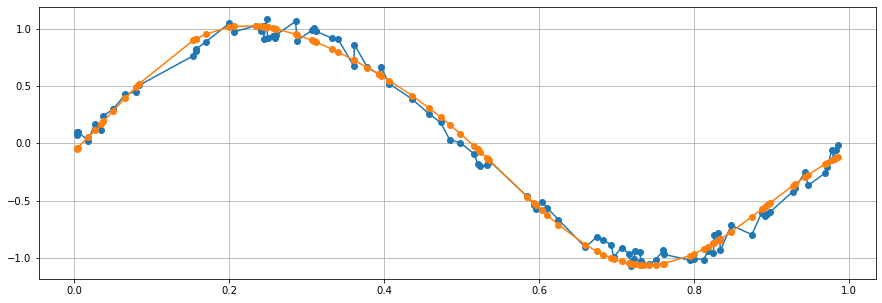

In [22]:
y_pred = inference(x)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x, y, '-o')
ax.plot(x, y_pred, '-o')
ax.grid() ; plt.show() 

In [23]:
(np.linalg.norm(y - y_pred)) ** 2

0.5808824447237665

## 5. Fine-tuning - obligatoriu

Realizaţi:
* implementarea algoritmului k-means++ pentru alegerea centroizilor initiali

## 6. Fine tuning - optional
* modificaţi numărul de clustere K şi găsiţi cea mai bună valoare
* regularizarea ponderilor stratului ascuns
* găsiţi cel mai bun parametru de regularizare şi cea mai bună rată de învăţare